In [847]:
import json
import ufl
import dolfin as dl

#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

from helpers import *
from generate_samples import *
from train_nn import *


# Setup Mesh, and Functional spaces and PDE

In [848]:
nx = 31; ny = 31
nodes = (nx+1)*(ny+1)
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


## Setup the Gempy

In [849]:
# 
# data = generate_input_output_gempy_data_(mesh=mesh, number_samples=100,nodes=nodes, filename=None)
# c,m_data, dmdc_data = np.array(data["input"]),np.array(data["Gempy_output"]), np.array(data["Jacobian_Gempy"])
# c.shape, type(c), m_data.shape, type(m_data),dmdc_data.shape, type(dmdc_data)

In [ ]:

direcoty_path="../Results/Nodes_"+str((nx+1)*(ny+1))

# Path to your JSON file
filename = direcoty_path+ "/data.json"
# Open and load the file
with open(filename, 'r') as file:
    data = json.load(file)

c, m_data, dmdc_data = np.array(data["input"]),np.array(data["Gempy_output"]), np.array(data["Jacobian_Gempy"])
n=7000 # Number of samples we need
c=c[:n]
m_data = m_data[:n]
dmdc_data = dmdc_data[:n]
#c.shape, type(c), m_data.shape, type(m_data),dmdc_data.shape, type(dmdc_data)

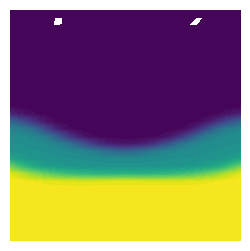

In [851]:
m = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_data[0,:][d2v])

plt.axis("off")
dl.plot(m,cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)

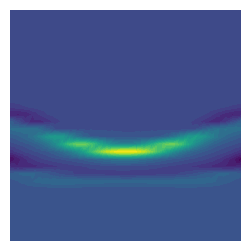

In [852]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,0][d2v])
plt.axis("off")
dl.plot(m_nodes_hat, cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)

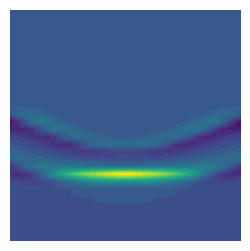

In [853]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,1][d2v])
plt.axis("off")
dl.plot(m_nodes_hat, cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)

## Generate samples of the state.


NOTE I AM USING A SIMPLE MPI RANK PROCESS SO THE ARRAY OPERATION `.get_local()` MAY NEED TO BE MODIFIED IN AN MPI PARALLEL CONTEXT. HOWEVER FOR PROBLEMS THAT ARE THIS SMALL THERE IS NO JUSTIFICATION FOR MPI PARALLELISM FOR THE MESH

In [854]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,M_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

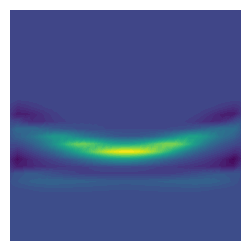

In [855]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,0][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
dl.plot(m_hat, cmap="viridis")
#dl.plot(m_nodes_hat)
fig = plt.gcf()
fig.set_size_inches(3, 3)

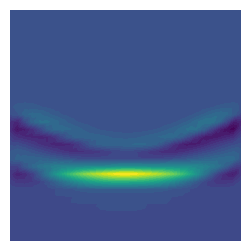

In [856]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,1][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
dl.plot(m_hat, cmap="viridis")
#dl.plot(m_nodes_hat)
fig = plt.gcf()
fig.set_size_inches(3, 3)

In [ ]:
nsamples = c.shape[0]

m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

dU = u.vector().get_local().shape[0]

dC = c.shape[1]

# once you have modified the means of c->m(c) comment this
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
u_data = np.zeros((nsamples,dU))
J_data = np.zeros((nsamples, dU, dC))

plotting = False
for sample_index in range(nsamples):
    # Do something here to modify the coefficients
   
    m_values = m_data[sample_index,:]
    m.vector().set_local(m_values[d2v]) #uncomment this
    # m.vector().set_local(m_values[d2v] +0.1*np.random.randn(m_values.shape[0])) #comment this
    if plotting:
        #plt.axis("off")
        dl.plot(m,cmap="viridis")
        fig = plt.gcf()
        fig.set_size_inches(1, 1)
        plt.show()
        # Plot with color

    
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    
    Jm.observable.setLinearizationPoint(x)
    
    
    # Get the data
    u_data[sample_index,:] = x[hp.STATE].get_local()
    # Calculate the Jacobian
    for component in range(dC):
        m_nodes_hat.vector().set_local(dmdc_data[sample_index,:,component][d2v]) 
        Jm.mult(m_nodes_hat.vector(),uhat.vector()) 
        # Multiply dmdc by Mass matrix.
        # M_M.mult(m_nodes_hat.vector(), m_hat.vector()) 
        # Jm.mult(m_hat.vector(),uhat.vector()) 
        
        J_data[sample_index,:,component] = uhat.vector().get_local()
    
u_data.shape, J_data.shape

((1000, 3969), (1000, 3969, 2))

## POD

In [858]:
# u_trial = dl.TrialFunction(Vh[hp.STATE])
# u_test = dl.TestFunction(Vh[hp.STATE])

# M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

POD = hf.PODProjectorFromData(Vh,M_output = M_U)

mean_shifting = True

# Change this later on to be chosen appropriately.
u_rank = len(u_data)
print(u_rank)
d, phi, Mphi, u_shift  = POD.construct_subspace(u_data, u_rank, shifted=mean_shifting, method='hep', verify=True)
phi.shape, Mphi.shape

1000
Using HEP
NOTE: number of data points 1000 is comparable to vector dimension 3969.
Recommend using method==ghep
Preprocessing took 0.242 seconds
Eigenvalue solve took 0.132 seconds
Postprocessing took 5.39 seconds
Basis Orthogonality error: 57.582078913516916
Basis-Projector Orthogonality error: 57.582078913516916
Mean reconstruction error: 5.378e-07
Max reconstruction error: 3.634e-06


((3969, 1000), (3969, 1000))

In [859]:
# phi.shape, Mphi.shape, d

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_23448/1568989377.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.arange(d.shape[0]), np.log10(d))


Text(0.5, 1.0, 'Eigenvalue distribution')

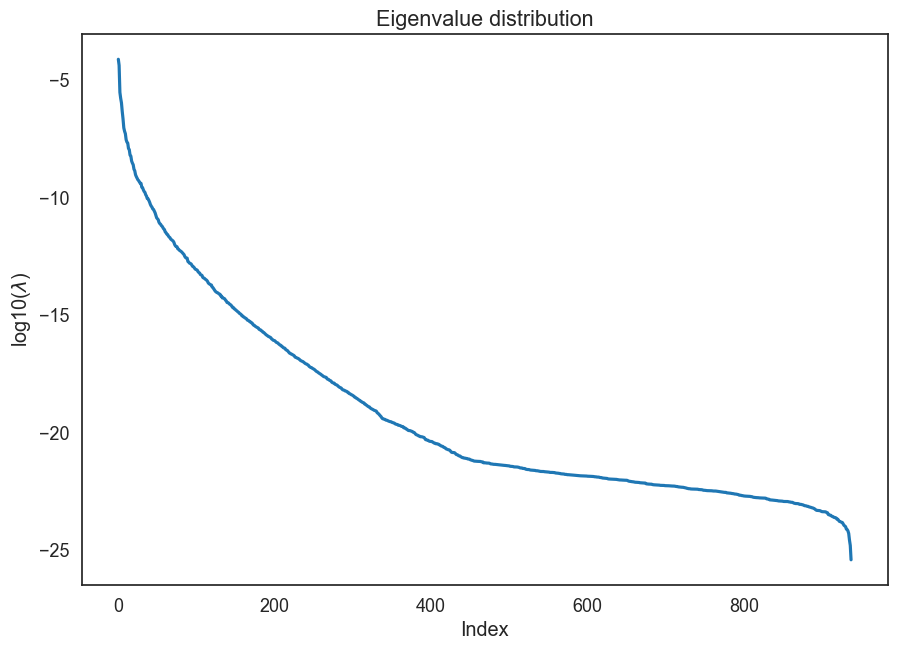

In [860]:
plt.plot(np.arange(d.shape[0]), np.log10(d))
plt.xlabel("Index")
plt.ylabel("log10($\lambda$)")
plt.title("Eigenvalue distribution")

In [861]:
r = np.sum(d>=1e-6)
r 

np.int64(5)

In [862]:

Mphi = Mphi[:, :r]
phi = phi[:,:r]
Mphi.shape, phi.shape

((3969, 5), (3969, 5))

In [863]:
## Compare reconstructions in POD basis

################################################################################
True state


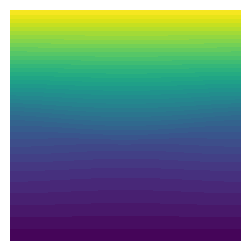

################################################################################
POD projected state


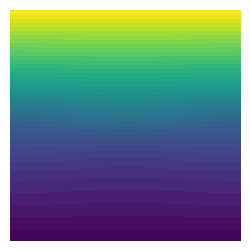

################################################################################
As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function


In [864]:
print(80*'#')
print('True state')
u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u, cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()

print(80*'#')
print('POD projected state')
u.vector().set_local(phi@Mphi.T@(u_data[0] - u_shift) + u_shift)
plt.axis("off")
dl.plot(u,cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()

print(80*'#')
print('As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function')

## (Linear) encoders and decoders.

Please consult our papers for a more in-depth discussion. E.g., [section 2.4 in this work](https://arxiv.org/abs/2411.12726)

We can expand a function on an orthonormal basis as

$$ u(x) = \sum_{i=1}^\infty \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

and the truncated representation

$$ u(x) = \sum_{i=1}^r \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

The encoder is the mapping from the data $u(x)$ to its truncated coefficient expansion $\mathcal{E}_r u \in \mathbb{R}^{r}$

$$ \mathcal{E}_r u = \left[\langle u,\phi_i\rangle_\mathcal{U}\right]_{i=1}^r \in \mathbb{R}^{r}$$

The decoder maps this data back to the function space (e.g., the basis expansion operation), given $\alpha \in \mathbb{R}^r$ we have

$$ \mathcal{D}_r \alpha  = \sum_{i=1}^r \alpha_i \phi_i$$

The encoder has the effect of the inner product $\langle \cdot,\cdot\rangle_\mathcal{U}$, e.g., the mass matrix in finite elements, each column of it is $\langle \cdot, \phi\rangle_\mathcal{U}$, so we call it `Mphi` $\in \mathbb{R}^{d_u \times r}$. Likewise we call the decoder `\phi` since its columns are just the basis vectors

### Encoding u data

The mapping to the coefficients of u is $u_r = \mathcal{E}_r u$. In numpy this is `ur_data = Mphi.T@u_data`

### Decoding the u data

We decode with the basis: $\mathcal{D}_r u_r$. In numpy this is `phi@ur_data`

### Encoding and decoding the derivatives.

The derivative of the map is 

$$ Du(c) \in \mathcal{L}(\mathbb{R}^{d_c},\mathcal{U}) $$

that is, the space of linear operators from $\mathbb{R}^{d_c}$ into $\mathcal{U}$. We want to remove the high-dimensionality associated with $\mathcal{U}$

This is done with the encoder operator:

$$\mathcal{E}_r Du(c) \in \mathbb{R}^{r\times d_c}$$

In [865]:
# Encode the u_data

ur = np.einsum('ur,du->dr',Mphi,u_data)

# Encoder the Du_data

# dc = 2
# Du_data = np.random.randn(nsamples,dU,dc)
# Dur_data = np.einsum('ur,duc->drc',Mphi,Du_data)

## Training data

The training data then is inputs (`c_data` \in $\mathbb{R}^{nsamples\times dc}$) and outputs (`ur_data`, `Dur_data`)


## To figure out in the $Du(c)$ calculations

The derivative I believe should have the mass matrix for $\mathcal{M}$ space in it:

$$ Du(c) = D_m(u(m(c)) \frac{dm}{dc} = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc}$$

In the other notebook we are evaluating the mapping from $c\mapsto m_\text{node}$, the nodal representation of $m$, but not the function. The mapping to the function requires the mass matrix

The torch gempy code will give you
$$ \frac{dm_\text{node}}{dc}$$

and we need in the end
$$ \frac{dm}{dc} = M_\mathcal{M} \frac{dm_\text{node}}{dc}$$

In [866]:
# Calculating the mass matrix for $\mathcal{M}$


In [867]:
# m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
# m_test = dl.TestFunction(Vh[hp.PARAMETER])

# M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

## Final form of the pre-reduced Jacobian

$$ Du(c) = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} M_\mathcal{M}\frac{dm_\text{node}}{dc}$$

Where 

$$ \frac{dm_\text{node}}{dc} \in \mathbb{R}^{d_\text{node}\times dc}$$

is the nodal Jacobian you will get as the output from the gempy torch automatic differntiation

## DOF ORDERING FOR m

You will also need to check the correct degree of freedom mapping for $m$

It will likely be something like the code we had: `m_values[d2v]`

So the output of your torch AD for dm_node/dc will need to have each column reordered using the d2v re-ordering.

When in doubt, plot everything. Do you see that I am constantly plotting to make sure that I am dealing with the right thing? If you get the vertex to dof map wrong you will be able to see it immediately via plotting columns of the Jacobian.

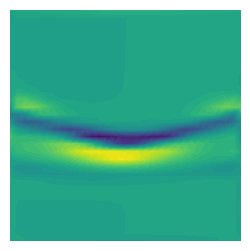

In [868]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[0,:,0])
plt.axis("off")
dl.plot(u_hat,cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)

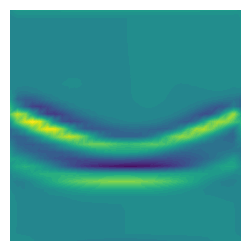

In [869]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[0,:,1])
plt.axis("off")
dl.plot(u_hat,cmap="viridis")
fig = plt.gcf()
fig.set_size_inches(3, 3)

In [870]:
Dur = np.einsum('ur,duc->drc',Mphi,J_data)
ur.shape, Dur.shape

((1000, 5), (1000, 5, 2))

In [871]:
train_network(Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([5, 5]) torch.Size([2, 2])
Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.9886, Val Loss: 5.2261
Epoch [10/100], Train Loss: 0.0044, Val Loss: 0.0192
Epoch [20/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [30/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [40/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [50/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [60/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [70/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0009
Epoch [99/100], Train Loss: 0.0001, Val Loss: 0.0009
L2 accuaracy without Jacobian:  tensor(0.9707, grad_fn=<RsubBackward1>)


In [872]:
train_network(network_type="full", Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([5, 5]) torch.Size([2, 2])
Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.5003, Val Loss: 2.6307, L2 Loss: 0.4946, F2 Loss: 0.0057
Epoch [10/100], Train Loss: 0.0023, Val Loss: 0.0098, L2 Loss: 0.0023, F2 Loss: 0.0000
Epoch [20/100], Train Loss: 0.0001, Val Loss: 0.0005, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [30/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [40/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [50/100], Train Loss: 0.0001, Val Loss: 0.0005, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [60/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [70/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [99/100], Train Loss: 0.0001, Val Loss

In [873]:
train_network(network_type=5, Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([5, 5]) torch.Size([2, 2])
Train size: 600,Valid size: 200,  Test size: 200
Epoch [0/100], Train Loss: 0.5003, Val Loss: 2.6307, L2 Loss: 0.4946, F2 Loss: 0.0057
Epoch [10/100], Train Loss: 0.0021, Val Loss: 0.0090, L2 Loss: 0.0021, F2 Loss: 0.0000
Epoch [20/100], Train Loss: 0.0001, Val Loss: 0.0005, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [30/100], Train Loss: 0.0001, Val Loss: 0.0005, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [40/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [50/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [60/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [70/100], Train Loss: 0.0001, Val Loss: 0.0005, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.0004, L2 Loss: 0.0001, F2 Loss: 0.0000
Epoch [99/100], Train Loss: 0.0001, Val Loss